In [1]:
import numpy as np
import networkx as nx


In [2]:
N = 20
Gsmall = nx.connected_watts_strogatz_graph(N, 4, .1, seed=42)
# Gbar = nx.barabasi_albert_graph(N, 3)
M = nx.to_numpy_array(Gsmall)

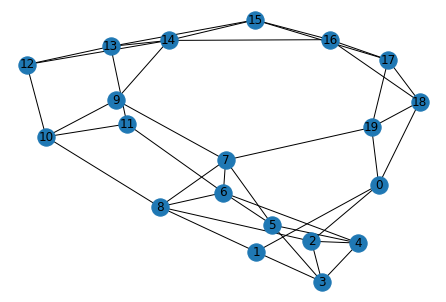

In [3]:
nx.draw(Gsmall,with_labels=True)

In [4]:
A = np.array([0, 1, 19], dtype=int)

# Volumes de graphes

**Question** Calculer le volume de $\mathrm{Vol}_{\mathbf{M}}(A)$ qui est la somme des degrés des noeuds de $A$ dans le graphe dont la matrice d'adjacence est $\mathbf{M}$. 

In [5]:
D = np.diag(M.sum(axis=1))
volA = D[A].sum()
print(volA)

11.0


In [6]:
volA = np.sum(M[A,:])
print(volA)

11.0


**Question** Quel est le volume de $\bar A$, le complémentaire de $A$ ? Comment aussi le calculer par le volume du graphe ?


*Aide* : On peut utiliser `np.setdiff1d` pour calculer une différence ensembliste ou passer par les ensembles de python.  

In [7]:
B = np.setdiff1d(np.arange(M.shape[0]), A)

In [8]:
D[B].sum()

69.0

In [9]:
D.sum()- volA, M.sum()- volA

(69.0, 69.0)

# Cuts : cas de la bisection  

**Question** Calculer le poids de toutes les arêtes qui lient un noeud de $A$ avec un noeud hors de $A$ dans le graphe dont la matrice d'adjacence est ${\mathbf M}$. C'est le $\mathrm{Cut}_{\mathbf M}(A,\bar A)$.

*Aide* : Si on range les noeuds dans la matrice d'adjacence selon $A$ et $\bar A$ on a 

$$\mathbf M = \begin{array}{|c|c|}\hline A\leftrightarrow A & A\to \bar A \\ \hline \bar A\to A &\bar A\leftrightarrow \bar A \\ \hline \end{array}$$
et on peut regarder uniquement le coin supérieur droit.

*Aide* : Voir [Advanced indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html#advanced-indexing). `X[[1,2],[3,4]]`  fonctionne comme du broadcast et ce n'est pas ce qu'on veut. On peut utiliser `np.ix_` ou deux fois un basic slicing... 
     

In [10]:
np.sum(M[A,:][:,B])


7.0

In [11]:
np.sum(M[A[:,np.newaxis],B])


7.0

In [12]:
np.sum(M[np.ix_(A,B)])


7.0

**Question** Écrire trois fonctions pour calculer le $\mathrm{Cut}_{\mathbf M}(A,\bar A)$, le $\mathrm{RatioCut}_{\mathbf M}(A,\bar A)$ et le $\mathrm{NCut}_{\mathbf M}(A,\bar A)$. Les fonctions prennent en argument une matrice d'adjacence et un ensemble d'indices de noeuds.

\begin{align*}
   \mathrm{Cut}_{\mathbf M}(A,\bar A)&= \sum_{i\in A,j\not\in A}M_{ij}\\
   \mathrm{RatioCut}_{\mathbf M}(A,\bar A)&=\mathrm{Cut}_{\mathbf M}(A,\bar A)\bigg (\frac{1}{\lvert A\rvert}+\frac{1}{{\lvert \bar A\rvert}}\bigg )\\
   \mathrm{NCut}_{\mathbf M}(A,\bar A) &= \mathrm{Cut}_{\mathbf M}(A,\bar A)\bigg (\frac{1}{\mathrm{Vol}(A)}+\frac{1}{\mathrm{Vol}(\bar A)}\bigg )
\end{align*}

In [13]:
def cut(W,A):
    B = np.setdiff1d(np.arange(W.shape[0]),A)
    return np.sum(W[A,:][:,B])


def ratioCut(W,A):
    return cut(W,A)*(1/A.size + 1/(W.shape[0]-A.size))


def nCut(W,A):
    volA = np.sum(W[A,:])
    return cut(W,A)*(1/volA + 1/(M.sum()-volA))

**Question** Calculer les 3 valeurs de cut pour les ensembles A suivants 

- 2
- 0, 1, 19
- 3, 10, 11, 15, 16, 17, 18
- 1, 2, 3, 4, 5, 6, 7, 8 ,9, 10 
- 2, 3, 6, 11, 12, 15, 16, 17, 18

Quel est le meilleur cut ? Le meilleur RatioCut et NCut ? 

In [14]:
As = [np.array([2], dtype=np.intp), 
      np.array([0, 1, 19], dtype=np.intp), 
      np.array([3,10,11,15,16,17,18], dtype=np.intp), 
      np.arange(11), 
      np.array([2, 3, 6, 11, 12, 15, 16, 17, 18]) ]

In [15]:
for A in As:
    print(A)
    print("{:>10} : {:}".format("Cut ",cut(M, A)))
    print("{:>10} : {:2.3f}".format("RatioCut", ratioCut(M, A)))  
    print("{:>10} : {:2.3f}".format("NCut", nCut(M, A)))
    print("-" * 10)

[2]
      Cut  : 4.0
  RatioCut : 4.211
      NCut : 1.053
----------
[ 0  1 19]
      Cut  : 7.0
  RatioCut : 2.745
      NCut : 0.738
----------
[ 3 10 11 15 16 17 18]
      Cut  : 15.0
  RatioCut : 3.297
      NCut : 0.839
----------
[ 0  1  2  3  4  5  6  7  8  9 10]
      Cut  : 7.0
  RatioCut : 1.414
      NCut : 0.356
----------
[ 2  3  6 11 12 15 16 17 18]
      Cut  : 21.0
  RatioCut : 4.242
      NCut : 1.067
----------


# Approche par des formes quadratiques

**Remarque** On peut s'inspirer des fonctions qui sont "smooth" sur le graphe pour définir un labelling des noeuds. Si on met +1 ou -1 comme label associé aux noeuds alors une fonction smooth sera sans doute celle qui réalisera un cut qui ne sera pas trop grand...  

**Question** Sans faire de calcul à la machine, quelle est la valeur de la forme quadratique $\mathbf f^\top \mathbf L \mathbf f$ si $\mathbf f$ est un labelling qui associe +1 au noeud numéro 2 et -1 à tous les autres ? 

*Réponse* : On sait que $\mathbf f^\top \mathbf L \mathbf f = \frac{1}{2}\sum_{i,j} \mathbf M_{ij}(\mathbf f_i - \mathbf f_j)^2$. Or, dans ce calcul seules les arêtes comptent entre 2 et les autres noeuds, soit 4 arêtes. Donc on a $\frac{1}{2}[(1 - (-1))^2+(1 - (-1))^2]\times 4$ soit 16.

**Question** Pour ces ensembles $A$ de la question précédente définir un labelling des noeuds qui mettent 1 aux noeuds de $A$ et -1 aux noeuds de $\bar A$

In [16]:
fs = []
for A in As:
    f = np.full(N, -1)
    f[A] = 1
    fs.append(f)

**Question** Calculer pour chaque labelling ainsi constitué $\mathbf f$, la valeur de $\mathbf f^\top \mathbf L\mathbf f$ où $\mathbf L$ est le laplacien du graphe. 

In [17]:
L = np.diag(M.sum(axis=1)) - M
for f in fs:
    print(f@L@f)

16.0
28.0
60.0
28.0
84.0


**Question** Quelle correspondance avez-vous trouvée ? Est-ce que minimiser cette forme quadratique trouve des cuts intéressants ? Pourquoi ?

*Réponse* : On calcule le $\mathrm{Cut}_{\mathbf M}(A, \bar A) = \frac{1}{2}\mathbf f^\top \mathbf L\mathbf f$ avec cette forme. Mais ce n'est pas un cut  très intéressant car il correspond souvent à des séparations triviales comme isoler un seul noeud qui n'a qu'un degré de 1. 

**Question** Calculer maintenant des  $\mathbf f$ en remplaçant les -1 par  $- \sqrt{\frac{\lvert A\rvert}{\lvert \bar A\rvert}}$ et les +1 par $\sqrt{\frac{\lvert \bar A\rvert}{\lvert A\rvert}}$. Que vaut $\sum_i \mathbf f_i$ ainsi que $\lVert \mathbf f\rVert_2$, la norme 2 de $\mathbf f$. Cacluler cela à la main et ensuite à la machine.

*Réponse* : 
$$ \sum_i\mathbf f_i = \lvert A\rvert \times \sqrt{\frac{\lvert \bar A\rvert}{\lvert A\rvert}} - \lvert \bar A\rvert \times \sqrt{\frac{\lvert A\rvert}{\lvert \bar A\rvert}}    = \sqrt{\lvert \bar A\rvert\lvert A\rvert} - \sqrt{\lvert A\rvert\lvert \bar A\rvert}= 0$$

$$ \sum_i\mathbf f_i^2 = \lvert A\rvert \times \frac{\lvert \bar A\rvert}{\lvert A\rvert} + \lvert \bar A\rvert \times \frac{\lvert A\rvert}{\lvert \bar A\rvert} = \lvert A\rvert + \lvert \bar A\rvert = N$$ 
Donc
$$ \lVert \mathbf f\rVert_2 = \sqrt{N}$$

In [18]:
fsn = []
for A in As:
    p = np.sqrt((N-A.size)/(A.size))
    m = - np.sqrt((A.size)/(N-A.size))
    f = np.full(N, m)
    f[A] = p
    fsn.append(f)
    print(A)
    print("{:>10} : {:2.3f}".format("Somme",f.sum()))
    print("{:>10} : {:2.3f}".format("Norme", np.linalg.norm(f)))

[2]
     Somme : -0.000
     Norme : 4.472
[ 0  1 19]
     Somme : -0.000
     Norme : 4.472
[ 3 10 11 15 16 17 18]
     Somme : 0.000
     Norme : 4.472
[ 0  1  2  3  4  5  6  7  8  9 10]
     Somme : -0.000
     Norme : 4.472
[ 2  3  6 11 12 15 16 17 18]
     Somme : 0.000
     Norme : 4.472


**Question** Montrer que $\mathbf f^\top \mathbf L\mathbf f = n\times \mathrm{RatioCut}(A, \bar A)$

*Réponse* : 

$\mathbf f^\top \mathbf L\mathbf f = \frac{1}{2}\sum_{ij} \mathbf M_{ij}(\mathbf f_i - \mathbf f_j)^2$. Mais dans cette somme, seuls comptent les $i$ et $j$ qui vont de $A$ vers $\bar A$ ou inversement. Donc 

$$\mathbf f^\top \mathbf L\mathbf f = \frac{1}{2}\sum_{i\in A, j\in \bar A} \mathbf M_{ij}(\mathbf f_i - \mathbf f_j)^2=\frac{1}{2}\sum_{i\in A, j\in \bar A} \mathbf M_{ij}\bigg(\sqrt{\frac{\lvert A\rvert}{\lvert \bar A\rvert}}+\sqrt{\frac{\lvert \bar A\rvert}{\lvert A\rvert}}\bigg)^2= \mathrm{Cut}_{\mathbf M}(A, \bar A)\frac{(\lvert A\rvert +\lvert \bar A\rvert)^2}{\lvert A\rvert \lvert \bar A\rvert}$$

Or 
$$\mathrm{RatioCut}_{\mathbf M}(A,\bar A)=\mathrm{Cut}_{\mathbf M}(A,\bar A)\bigg (\frac{1}{\lvert A\rvert}+\frac{1}{{\lvert \bar A\rvert}}\bigg ) = \mathrm{Cut}_{\mathbf M}(A,\bar A)\frac{(\lvert A\rvert +\lvert \bar A\rvert)}{\lvert A\rvert \lvert \bar A\rvert}$$

Donc 
$$\mathbf f^\top \mathbf L\mathbf f = (\lvert A\rvert +\lvert \bar A\rvert)\mathrm{RatioCut}_{\mathbf M}(A,\bar A) = N\times \mathrm{RatioCut}_{\mathbf M}(A,\bar A)$$

**Question** Calculer les formes quadratiques. Que constatez-vous? 

In [19]:
for f, A in zip(fsn, As):
    print(A)
    rc = ratioCut(M, A)
    print("{:>20} : {:2.3f}".format("forme quadratique", f@L@f))
    print("{:>20} : {:2.5f}".format("Ratio cut", rc))
    print("{:>20} : {:2.5f}".format("N*Ratio cut", N*rc))

[2]
   forme quadratique : 84.211
           Ratio cut : 4.21053
         N*Ratio cut : 84.21053
[ 0  1 19]
   forme quadratique : 54.902
           Ratio cut : 2.74510
         N*Ratio cut : 54.90196
[ 3 10 11 15 16 17 18]
   forme quadratique : 65.934
           Ratio cut : 3.29670
         N*Ratio cut : 65.93407
[ 0  1  2  3  4  5  6  7  8  9 10]
   forme quadratique : 28.283
           Ratio cut : 1.41414
         N*Ratio cut : 28.28283
[ 2  3  6 11 12 15 16 17 18]
   forme quadratique : 84.848
           Ratio cut : 4.24242
         N*Ratio cut : 84.84848


*Réponse* : Le meilleur résultat est avec `[ 3 11 18 15  2 12  6 16 17]` qui a un cut relativement bas et un ratio entre les deux sous ensembles de noeuds proche de 1/2.  On retrouve l'identité de la forme quadratique qui vaut $N$ fois le ratio cut .

**Question** On peut vérifier que si on définit $\mathbf f$ en remplaçant les -1 par  $- \sqrt{\frac{\mathrm{Vol}(A)}{\mathrm{Vol}(\bar A)}}$ et les +1 par $\sqrt{\frac{\mathrm{Vol}( \bar A)}{\mathrm{Vol}(A)}}$, on retrouve les même identités avec le $\mathrm{Ncut}$.

**Question** Calculer la décomposition spectrale de $\mathbf L$. Faire un ensemble avec les noeuds correspondant à une valeur positive dans le deuxième vecteur propre de cette décomposition. Calculer le ratioCut

In [20]:
E, V = np.linalg.eig(L)

In [21]:
indtri = np.argsort(E)
fiedler = V[:,indtri[1]]
fiedler

array([ 0.10864906,  0.25658328,  0.27421505,  0.33267571,  0.31629523,
        0.27954956,  0.18472851,  0.1130261 ,  0.17103965, -0.10249119,
       -0.07826859, -0.06957848, -0.26403524, -0.27251665, -0.27936409,
       -0.30993003, -0.2764884 , -0.22124323, -0.12582124, -0.03702501])

In [22]:
np.linalg.norm(fiedler)

0.9999999999999999

In [23]:
f2 = np.sign(fiedler)
f2

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.])

In [24]:
Af2 = np.argwhere(f2==1).flatten()
As.append(Af2)
Af2

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [25]:
for A in As:
    print(A)
    print(ratioCut(M, A))
    print("-" * 10)

[2]
4.2105263157894735
----------
[ 0  1 19]
2.7450980392156863
----------
[ 3 10 11 15 16 17 18]
3.2967032967032965
----------
[ 0  1  2  3  4  5  6  7  8  9 10]
1.4141414141414141
----------
[ 2  3  6 11 12 15 16 17 18]
4.242424242424242
----------
[0 1 2 3 4 5 6 7 8]
1.2121212121212122
----------


**Question** Reprendre la décomposition spectrale mais cette fois faire un $k$-means avec $k =2$ sur les valeurs de ce vecteur. 

In [26]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2)
km.fit(fiedler[:,np.newaxis])
km.labels_

/Users/islambendaoud/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [27]:
Afk2 = np.argwhere(km.labels_==1).flatten()
As.append(Afk2)
for A in As:
    print(A)
    print(ratioCut(M, A))
    print("-" * 10)

[2]
4.2105263157894735
----------
[ 0  1 19]
2.7450980392156863
----------
[ 3 10 11 15 16 17 18]
3.2967032967032965
----------
[ 0  1  2  3  4  5  6  7  8  9 10]
1.4141414141414141
----------
[ 2  3  6 11 12 15 16 17 18]
4.242424242424242
----------
[0 1 2 3 4 5 6 7 8]
1.2121212121212122
----------
[0 1 2 3 4 5 6 7 8]
1.2121212121212122
----------


**Question** Regarder la [documentation de sklearn à propos du spectral clustering](https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering-graphs). Appliquer cela sur la matrice $\mathbf M$. Calculer le ratioCut. (Remarquez que sklearn fait une projection du Laplacien normalisé).

In [28]:
from sklearn.cluster import SpectralClustering

In [29]:
specClust = SpectralClustering(affinity = 'precomputed', 
                               assign_labels="discretize",
                               n_init=100,
                               n_clusters=2)
classes = specClust.fit_predict(M)

In [30]:
Ask = np.argwhere(classes==1).flatten()
As.append(Ask)

In [31]:
for A in As:
    print(A)
    print(ratioCut(M, A))
    print("-" * 10)

[2]
4.2105263157894735
----------
[ 0  1 19]
2.7450980392156863
----------
[ 3 10 11 15 16 17 18]
3.2967032967032965
----------
[ 0  1  2  3  4  5  6  7  8  9 10]
1.4141414141414141
----------
[ 2  3  6 11 12 15 16 17 18]
4.242424242424242
----------
[0 1 2 3 4 5 6 7 8]
1.2121212121212122
----------
[0 1 2 3 4 5 6 7 8]
1.2121212121212122
----------
[0 1 2 3 4 5 6 7 8]
1.2121212121212122
----------
